In [29]:
# import & set-up
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [30]:
# pixel normalization
transform = transforms.Compose([
    transforms.ToTensor()
])

# download dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [31]:
# LeNet Model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1   = nn.Linear(320, 50)
        self.fc2   = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [32]:
# train, validation, test
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return test_loss / len(test_loader), 100. * correct / len(test_loader.dataset)

In [21]:
# training baseline
model = LeNet().to(device)

# Simpan initial weights untuk eksperimen pruning nanti
initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    train_losses.append(train_loss)
    test_accuracies.append(test_acc)
    print(f"[Baseline] Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Accuracy = {test_acc:.2f}%")

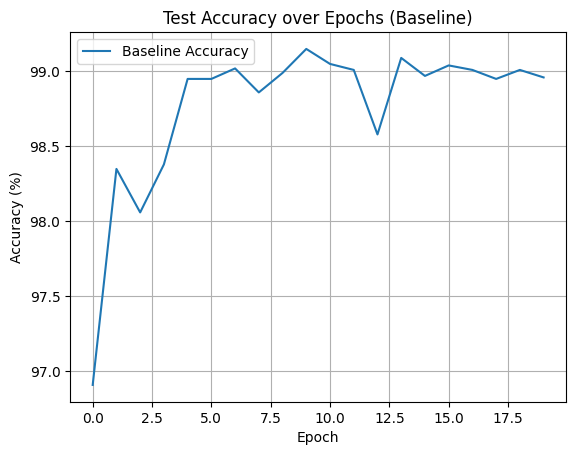

In [34]:
# plot baseline
plt.plot(test_accuracies, label='Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs (Baseline)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# prunning concept fit to paper for reproduce
def prune_by_percentile(model, prune_percent):
    all_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            all_weights += list(param.abs().flatten().cpu().detach().numpy())
    threshold = np.percentile(np.array(all_weights), prune_percent)

    mask_dict = {}
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            mask = (param.abs() > threshold).float()
            mask_dict[name] = mask
    return mask_dict

def apply_mask_and_reset(model, initial_weights, mask_dict):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask_dict:
                param.copy_(initial_weights[name] * mask_dict[name])


# iterative prunning if really want to get exact plot like paper(based on papers)
# def run_experiment(prune_percent=20, max_iterations=5, early_stop_patience=3):
#     all_final_accuracies = []

#     for trial in range(5):
#         print(f"\n Trial {trial + 1}")
#         model = LeNet().to(device)
#         initial_weights = {k: v.clone() for k, v in model.state_dict().items()}
#         current_mask = {k: torch.ones_like(v) for k, v in initial_weights.items() if 'weight' in k}

#         for iteration in range(max_iterations):
#             print(f"\n Iteration {iteration + 1}/{max_iterations}")
#             model.load_state_dict(initial_weights)
#             apply_mask_and_reset(model, initial_weights, current_mask)

#             optimizer = optim.Adam(model.parameters(), lr=0.001)
#             criterion = nn.CrossEntropyLoss()

#             best_val_acc = 0
#             patience = 0
#             epoch = 0
#             max_epoch = 50
#             last_test_acc = 0

#             while epoch < max_epoch and patience < early_stop_patience:
#                 train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
#                 val_loss, val_acc = validate(model, device, val_loader, criterion)
#                 test_loss, test_acc = test(model, device, test_loader, criterion)

#                 if val_acc > best_val_acc:
#                     best_val_acc = val_acc
#                     patience = 0
#                 else:
#                     patience += 1

#                 epoch += 1
#                 print(f"[Epoch {epoch}] Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%")
#                 last_test_acc = test_acc

#             all_final_accuracies.append(last_test_acc)
#             current_mask = prune_by_percentile(model, prune_percent, current_mask)

#     mean_acc = np.mean(all_final_accuracies)
#     std_acc = np.std(all_final_accuracies)
#     print(f"\n Final Test Accuracy over {5 * max_iterations} runs: {mean_acc:.2f}% ± {std_acc:.2f}%")
#     return all_final_accuracies

In [36]:
# prunning and retraining
prune_percent = 20
mask_dict = prune_by_percentile(model, prune_percent)

# Reset model dan apply mask
model = LeNet().to(device)
apply_mask_and_reset(model, initial_state_dict, mask_dict)

optimizer = optim.Adam(model.parameters(), lr=0.001)

retrain_accuracies = []
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    retrain_accuracies.append(test_acc)
    print(f"[Pruned] Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Accuracy = {test_acc:.2f}%")

[Pruned] Epoch 1: Train Loss = 0.2659, Test Accuracy = 97.55%
[Pruned] Epoch 2: Train Loss = 0.0788, Test Accuracy = 98.55%
[Pruned] Epoch 3: Train Loss = 0.0567, Test Accuracy = 98.65%
[Pruned] Epoch 4: Train Loss = 0.0445, Test Accuracy = 98.85%
[Pruned] Epoch 5: Train Loss = 0.0360, Test Accuracy = 98.84%
[Pruned] Epoch 6: Train Loss = 0.0326, Test Accuracy = 98.92%
[Pruned] Epoch 7: Train Loss = 0.0267, Test Accuracy = 98.85%
[Pruned] Epoch 8: Train Loss = 0.0236, Test Accuracy = 98.99%
[Pruned] Epoch 9: Train Loss = 0.0212, Test Accuracy = 98.56%
[Pruned] Epoch 10: Train Loss = 0.0189, Test Accuracy = 99.20%
[Pruned] Epoch 11: Train Loss = 0.0155, Test Accuracy = 99.13%
[Pruned] Epoch 12: Train Loss = 0.0148, Test Accuracy = 99.05%
[Pruned] Epoch 13: Train Loss = 0.0125, Test Accuracy = 99.09%
[Pruned] Epoch 14: Train Loss = 0.0111, Test Accuracy = 98.93%
[Pruned] Epoch 15: Train Loss = 0.0103, Test Accuracy = 98.78%
[Pruned] Epoch 16: Train Loss = 0.0088, Test Accuracy = 98.91%
[

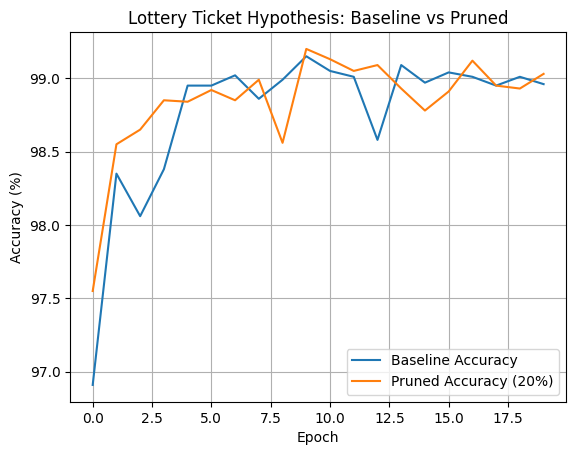

In [38]:
# plot baseline vs prunned 
plt.plot(test_accuracies, label='Baseline Accuracy')
plt.plot(retrain_accuracies, label=f'Pruned Accuracy ({prune_percent}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Lottery Ticket Hypothesis: Baseline vs Pruned')
plt.legend()
plt.grid(True)
plt.show()

# run for iterative training for iterative function 
# result_accs = run_experiment(prune_percent=20, max_iterations=5, early_stop_patience=3)

In [37]:
# final plot for iterative prunning function

# plt.plot(result_accs, marker='o')
# plt.xlabel('Iteration')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Test Accuracy across Iterative Pruning (5 Trials)')
# plt.grid(True)
# plt.show()